In this notebook, I will mainly add embeddings. <br>

In [1]:
%cd ..
%cd root
import numpy as np
import pandas as pd
df = pd.read_csv("dwdata_3.csv")
df.head()
df.fillna('', inplace=True)
print(len(df))
x_1 = df["xx"].tolist()
y_1 = df["yy"].tolist()

/
/root
76543


In [11]:
word2vec_index = {}
f = open("glove.6B.100d.txt",encoding="utf8")
for line in f:
    words = line.split()
    word = words[0]
    index = np.asarray(words[1:], dtype="float32")
    word2vec_index[word] = index
f.close()

print("The number of word vectors are: ", len(word2vec_index))

The number of word vectors are:  400000


In [6]:
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.sequence import pad_sequences
token = tfds.features.text.SubwordTextEncoder.build_from_corpus(x_1+y_1, target_vocab_size=1e12)

vocab_size = token.vocab_size + 2 # adding the start and end characters

inputs = [token.encode(sentence) for sentence in x_1]
outputs = [[vocab_size - 2] + token.encode(sentence) + [vocab_size - 1] for sentence in y_1]
print("{},{}".format(len(inputs),len(outputs)))
df["sent_len"] = [len(sent) for sent in inputs]
MAXLEN = 50
idx_to_shorten = [count for count, sent in enumerate(inputs) if len(sent) > MAXLEN]
for idx in idx_to_shorten:
    inputs[idx] = inputs[idx][:MAXLEN]
    outputs[idx] = outputs[idx][:MAXLEN]
idx_to_shorten = []
idx_to_shorten = [count for count, sent in enumerate(outputs) if len(sent) > MAXLEN]
for idx in idx_to_shorten:
    inputs[idx] = inputs[idx][:MAXLEN]
    outputs[idx] = outputs[idx][:MAXLEN]
# deleted min len because short convos are still good :)
inputs = pad_sequences(inputs, value=0, padding="post", maxlen=MAXLEN)
outputs = pad_sequences(outputs, value=0, padding="post", maxlen=MAXLEN)
print("{},{}".format(inputs.shape,outputs.shape))

76543,76543
(76543, 50),(76543, 50)


In [0]:
df.head()

,Unnamed: 0,X,Y,X_1,Y_1,xx,yy,sent_len
0,0,im pleased you two are so impressed i find the...,yes i suppose the atmosphere is rather rancid,im pleased you two are so impressed i find the...,yes i suppose the atmosphere is rather rancid,im pleased you two are so impressed i find the...,yes i suppose the atmosphere is rather,11
1,1,hes let us go,he needs to move his tardis into the circle of...,hes let us go,he needs to move his tardis into the circle of...,he is let us go,he needs to move his tardis into the circle of...,5
2,2,without special treatment it would have spread...,ah thats nice,without special treatment it would have spread...,ah thats nice,without special treatment it would have spread...,ah thats nice,11
3,3,when i came back with these satellite reports ...,nothings been moved,when i came back with these satellite reports ...,nothings been moved,when i came back with the ise satellite report...,nothings been moved,19
4,4,there it is but he could be anywhere,fair exchange is no robbery the masters tempor...,there it is but he could be anywhere,fair exchange is no robbery the masters tempor...,there it is but he could be anywhere,fair exchange is no robbery the masters tempor...,8


In [0]:
vocab = set()
for sentence in (x_1 + y_1):
    words = sentence.split(" ")
    for word in words:
        if word not in vocab:
            vocab.add(word)

In [12]:
embedding_matrix = np.zeros((vocab_size, 100))
count = 0
count_1 = 0
not_glove = []
for i, word in enumerate(token.subwords):
    if (word[-1] == "_"):
        word = word[:-1]
    embedding_vector = word2vec_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
        count_1 += 1
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(100)
        not_glove.append(word)
        count += 1
print("In GLOVE: {}, Not in GLOVE: {}".format(count_1, count))
# HALF OF THE WORDS ARE NOT IN GLOVE WHYYYYYYYYYYY (glove.6B.100d)
# The updated version has 92% of the vocab in glove! Yay!

In GLOVE: 11558, Not in GLOVE: 703


In [13]:
from scipy.ndimage.interpolation import shift
inputs_1 = inputs
inputs_2 = outputs
outputs_1 = outputs
outputs_1 = shift(outputs_1, [0,-1], cval=0)
print("{},{}".format(inputs_1.shape,outputs_1.shape))

(76543, 50),(76543, 50)


In [0]:
vocab_size

12520

In [0]:
# from tqdm import tqdm
# x1 = []
# x2 = []
# y1 = []
# for sentence in tqdm(inputs_1):
#   sentence1 = []
#   for index in sentence:
#     onehot = np.zeros((vocab_size))
#     onehot[index] = 1
#     sentence1.append(onehot)
#   x1.append(sentence1)
# for sentence in tqdm(inputs_2):
#   sentence1 = []
#   for index in sentence:
#     onehot = np.zeros((vocab_size))
#     onehot[index] = 1
#     sentence1.append(onehot)
#   x2.append(sentence1)
# for sentence in tqdm(outputs_1):
#   sentence1 = []
#   for index in sentence:
#     onehot = np.zeros((vocab_size))
#     onehot[index] = 1
#     sentence1.append(onehot)
#   y1.append(sentence1)

  6%|▋         | 4929/76543 [00:13<04:18, 276.60it/s]

In [0]:
#https://towardsdatascience.com/how-to-implement-seq2seq-lstm-model-in-keras-shortcutnlp-6f355f3e5639
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional, Dropout, TimeDistributed
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model
# latent_dim = 256
# Shared_Embedding = Embedding(vocab_size,100,weights=[embedding_matrix],input_length=MAXLEN,trainable=True)

# encoder_inputs = Input(shape=(MAXLEN), dtype='int32')
# encoder_embedding = Shared_Embedding(encoder_inputs)
# encoder_outputs, state_h, state_c = LSTM(latent_dim, return_state = True)(encoder_embedding)

# decoder_inputs = Input(shape=(MAXLEN), dtype='int32')
# decoder_embedding = Shared_Embedding(decoder_inputs)
# decoder_outputs, _, _ = LSTM(latent_dim, return_state=True, return_sequences=True)(decoder_embedding, initial_state=[state_h, state_c])

# outputs_model = Dense(1, activation='softmax')(decoder_outputs)
# model = Model([encoder_inputs, decoder_inputs], outputs_model)

# model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=2), metrics=['accuracy'])

latent_dim = 256
encoder_inputs = Input(shape=(MAXLEN,1))
lstm = LSTM(latent_dim, return_state = True)
encoder_outputs, state_h, state_c = lstm(encoder_inputs)

decoder_inputs = Input(shape=(MAXLEN,1))
lstm1 = LSTM(latent_dim, return_state=True, return_sequences=True)
decoder_outputs, _, _ = lstm1(decoder_inputs, initial_state=[state_h, state_c])

outputs_model = Dense(1, activation='softmax')(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], outputs_model)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.05))

In [0]:
sub = 10
hist = model.fit([inputs_1[:sub], inputs_2[:sub]], outputs_1[:sub],batch_size=32,epochs=50,validation_split=0.2, verbose = 0)
model.save("3rd_m.h5")

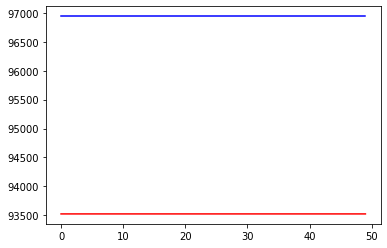

In [76]:
import matplotlib.pyplot as plt
plt.plot(hist.history["loss"],color="r")
plt.plot(hist.history["val_loss"],color="b")

In [0]:
# use bidirectional lstm next time?
#https://github.com/oswaldoludwig/Adversarial-Learning-for-Generative-Conversational-Agents !!!!GAANNN!!!!
# Put attention in as well!

In [27]:
print(inputs_2[1][0])
print(inputs_2[2][0])

12518
12518


In [51]:
def decode_sequence(input_seq):
    # input_seq = np.expand_dims(input_seq,axis=-1)
    partial = np.zeros((1,MAXLEN))
    partial[0,0] = vocab_size-2
    decoded_sentence = []
    for _ in range(MAXLEN-1):
        pred = model.predict([input_seq, partial])
        partial[0,:] = pred[0,:,0]
    # pred = token.decode([int(i) for i in decoded_sentence])
    return partial[0]
index_try = 33
input_seq = inputs_1[index_try: index_try + 1]
pred = decode_sequence(input_seq)
print('-')
print('Input sentence:', token.decode(inputs_1[index_try]))
print('Decoded sentence:', pred)

-
Input sentence: keep your eyes he cant have got far
Decoded sentence: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
